In [1]:
! eups list -s lsst_distrib

   21.0.0-2-g8e5b5ee+8459b0669c 	w_2021_20 w_latest current setup


In [1]:
import numpy
import pylab

# Stack imports
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.meas.extensions.shapeHSM
import lsst.afw.image as afwImage
from lsst.ip.isr.isrTask import IsrTask
from lsst.obs.lsst import LsstCam
from lsst.cp.pipe import BrighterFatterKernelSolveTask    

In [2]:
def mkplot(bfk, meta=None):
    numpy.seterr(divide = 'ignore') 
    for ch in range(16):
        fig, axs = pylab.subplots(1, 5, figsize=(20,5),facecolor='w')
        for i,(akey,label,sign,func) in enumerate([
            ("MEAN_XCORRS","COVARIANCE",-1, numpy.vectorize(lambda x: numpy.log10(abs(x))) ),
            ("KERNEL","KERNEL",1, numpy.vectorize(lambda x: x))
        ]):
            pixtable = bfk.getDict()["outputBFK"].toTable()[0][akey][ch]
            axs[0+2*i].set_title(label)
            axs[0+2*i].imshow(func(pixtable.reshape(17,17)))
            axs[1+2*i].plot(pixtable.reshape(17,17)[:,8]*sign,color="blue",drawstyle='steps-mid')
            axs[1+2*i].plot(pixtable.reshape(17,17)[8,:]*sign,color="red",drawstyle='steps-mid',linestyle='--')
            axs[1+2*i].grid()
            fig.suptitle("{} {}".format(meta, ch))

        i=2*i+2
        line=bfk.getDict()["outputBFK"].toTable()[0][ch]
        x = line["MEANS"]
        y = line["VARIANCES"]
        axs[i].set_xlabel("MEANS")
        axs[i].set_ylabel("VARIANCES")    
        axs[i].plot(x,y,"o")
        xarr = numpy.arange(numpy.nanmin(x),numpy.nanmax(x))
        axs[i].plot(xarr, line["NOISE"]+xarr/line["GAIN"])
        axs[i].loglog()
        axs[i].set_title( "G={:.3} noise={:.3}".format(line["GAIN"], line["NOISE"]) )
        fig.tight_layout()
        fig.show()
    numpy.seterr(divide = 'warn')

# Get the Data

In [3]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/butler.yaml"
butler = Butler(repo_path)
#collections = "/calib/run_12781_v3"
#collections = 'LSSTCam/raw/all,LSSTCam/calib,u/youtsumi/run_12781/bf_work/ptcs/20210610T163510Z'.split(",") ## the original PTC, Astier EXA...
collections = 'LSSTCam/raw/all,LSSTCam/calib,u/youtsumi/run_12781/bf_work_v3/ptcs/20210619T212901Z'.split(",") ## POLYNOMIAL
#collections = 'LSSTCam/raw/all,LSSTCam/calib,u/youtsumi/run_12781/bf_work_v4/ptcs/20210620T164944Z'.split(",") ## FULL COVARIANCE
#collections = 'LSSTCam/raw/all,LSSTCam/calib,u/youtsumi/run_12781/bf_work_v5/ptcs/20210620T231305Z'.split(",") ## EXPAPPROXIMATION again

where = """
instrument='LSSTCam'
and detector = 29
and exposure.observation_type = 'spot'
"""

subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections,where = where))
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )



datasetRefs = list(subregistry.queryDatasets(datasetType="ptc",collections=collections[-1]))
ccd_kernels_polynomial = []
for num, adatasetRef in enumerate(datasetRefs):
    ptc = subbutler.get(adatasetRef)
    rawref = list(subregistry.queryDatasets(datasetType="raw",dataId=adatasetRef.dataId))
    print(rawref[0].dataId)
    raw = subbutler.get(rawref[0])
    bfk = BrighterFatterKernelSolveTask()
    bfk.config.forceZeroSum = True
    bfk.config.correlationModelRadius = 3
    new = bfk.run(ptc,[raw],LsstCam().getCamera(),adatasetRef.dataId)
    ccd_kernels_polynomial.append(new.getDict()['outputBFK'])



1319 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
3913 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
3913 DatasetType('packages', {}, Packages)
Error DatasetType('camera', {instrument}, Camera, isCalibration=True)
0 DatasetType('cpDarkIsr', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDarkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDark_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('dark', {instrument, detector}, ExposureF, isCal

In [4]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/butler.yaml"
butler = Butler(repo_path)
#collections = "/calib/run_12781_v3"
#collections = 'LSSTCam/raw/all,LSSTCam/calib,u/youtsumi/run_12781/bf_work/ptcs/20210610T163510Z'.split(",") ## the original PTC, Astier EXA...
#collections = 'LSSTCam/raw/all,LSSTCam/calib,u/youtsumi/run_12781/bf_work_v3/ptcs/20210619T212901Z'.split(",") ## POLYNOMIAL
#collections = 'LSSTCam/raw/all,LSSTCam/calib,u/youtsumi/run_12781/bf_work_v4/ptcs/20210620T164944Z'.split(",") ## FULL COVARIANCE
collections = 'LSSTCam/raw/all,LSSTCam/calib,u/youtsumi/run_12781/bf_work_v5/ptcs/20210620T231305Z'.split(",") ## EXPAPPROXIMATION again

where = """
instrument='LSSTCam'
and detector = 29
and exposure.observation_type = 'flat'
"""
#collections = 'u/echarles/calib/bias/run_12781/20210326T180033Z'
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections,where = where))
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )


datasetRefs = list(subregistry.queryDatasets(datasetType="ptc",collections=collections[-1]))
ccd_kernels_exapproximation = []
for num, adatasetRef in enumerate(datasetRefs):
    ptc = subbutler.get(adatasetRef)
    rawref = list(subregistry.queryDatasets(datasetType="raw",dataId=adatasetRef.dataId))
    print(rawref[0].dataId)
    raw = subbutler.get(rawref[0])
    bfk = BrighterFatterKernelSolveTask()
    bfk.config.forceZeroSum = True
    bfk.config.correlationModelRadius = 3
    new = bfk.run(ptc,[raw],LsstCam().getCamera(),adatasetRef.dataId)
    ccd_kernels_exapproximation.append(new.getDict()['outputBFK'])

114 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
72 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
114 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
114 DatasetType('packages', {}, Packages)
Error DatasetType('camera', {instrument}, Camera, isCalibration=True)
0 DatasetType('cpDarkIsr', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDarkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDark_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
Error DatasetType('dark', {instrument, detector}, ExposureF, isCalib

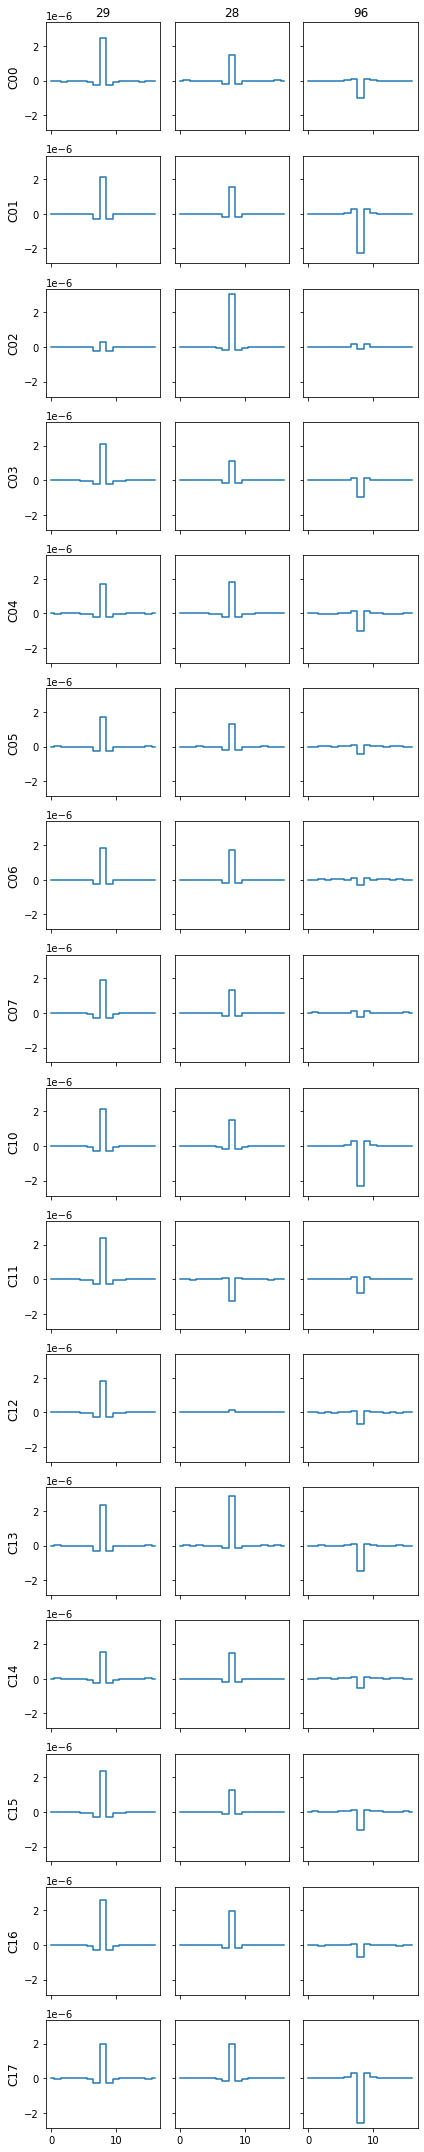

In [5]:
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(16,3, sharex=True, sharey=True, figsize=(6,30))

for ccd in range(3):
    for i in range(16):
        ax = axs[i][ccd]
        bfk_polynomial = ccd_kernels_polynomial[ccd].toTable()[0]["MEAN_XCORRS"][i].reshape(17,17)
        bfk_exapproximation = ccd_kernels_exapproximation[ccd].toTable()[0]["MEAN_XCORRS"][i].reshape(17,17)

        ax.plot(np.asarray(bfk_polynomial[:,8]) - np.asarray(bfk_exapproximation[:,8]), drawstyle='steps-mid')
        
cols = ['29','28','96']
rows = ccd_kernels_polynomial[ccd].toTable()[0]["AMPLIFIER"].flatten()

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, size='large')
    

plt.tight_layout()


In [11]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/butler.yaml"
butler = Butler(repo_path)
collections = 'LSSTCam/raw/all'

where = "instrument='LSSTCam' AND detector in ( 29 ) AND exposure.observation_type='spot' AND exposure.seq_num IN (623) AND exposure.science_program IN ( '12788' )"


subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections,where = where))
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )


1 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
0 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
0 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
0 DatasetType('packages', {}, Packages)
0 DatasetType('camera', {instrument}, Camera, isCalibration=True)
0 DatasetType('cpDarkIsr', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDarkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDark_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
0 DatasetType('dark', {instrument, detector}, ExposureF, isCalibration=True)
0 Data

In [13]:
datasetRefs = list(subregistry.queryDatasets(datasetType="raw",collections=collections,where = where))
for num, adatasetRef in enumerate(datasetRefs):
    print(adatasetRef.dataId)
    raw = subbutler.get(adatasetRef)
    md = raw.getMetadata()
    
    print(md)
    
    #rawref = list(subregistry.queryDatasets(datasetType="raw",dataId=adatasetRef.dataId))
    #print(rawref[0].dataId)
    #raw = subbutler.get(rawref[0])

{instrument: 'LSSTCam', detector: 29, exposure: 3020112600623, ...}


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201126/MC_C_20201126_000623/MC_C_20201126_000623_R10_S02.fits(MC_C_20201126_000623): Unable to determine the filter


SIMPLE = 1
// Java FITS: Mon Nov 23 12:10:03 PST 2020
EXTEND = 1
// Extensions are permitted
DATE = "2020-11-26T22:53:28.305"
// Creation Date and Time of File
MJD = 59179.953799827
// Modified Julian Date that the file was written
RUNNUM = "12788"
// The Run Number
CCD_MANU = "ITL"
// CCD Manufacturer
CCD_TYPE = "3800C"
// CCD Model Number
TESTTYPE = "SPOT_FLAT"
// BIAS, DARK, FE55, FLAT, LAMBDA, PERSISTENCE, SPOT, SFLAT
IMGTYPE = "SPOT"
// BIAS, DARK, FE55, FLAT, FLAT_<lam>, SPOT, PPUMP
EXPTIME = 28.000000000000
// Exposure Time in Seconds
BINX = 1
// [pixels] binning along X axis
BINY = 1
// [pixels] binning along Y axis
CCDGAIN = 1.0000000000000
// Rough guess at overall system gain (e-/DNB)
CCDNOISE = 10.000000000000
// Rough guess at system noise (e- rms)
DATE-OBS = "2020-11-26T22:53:28.301"
// Date of the image trigger (readout), UTC f
MJD-OBS = 59179.953799780
// Modified Julian Date of image trigger
DATE-TRG = "2020-11-26T22:53:28.301"
// Date of the image trigger (readout), U